In [ ]:
#! pip install image-similarity-measures

In [39]:
import nibabel as nib
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from pathlib import Path
from ipywidgets import IntSlider, interact
import pywt
import cv2
import dicom2nifti
from skimage import exposure
from image_similarity_measures.quality_metrics import fsim

In [2]:
def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(12,8))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [3]:
#convert dicom to nii.gz
#dicom2nifti.dicom_series_to_nifti('0_1', '0_1.nii.gz', reorient_nifti=True)

In [4]:
#download 3d brain image
brain = nib.load('0_1.nii.gz')

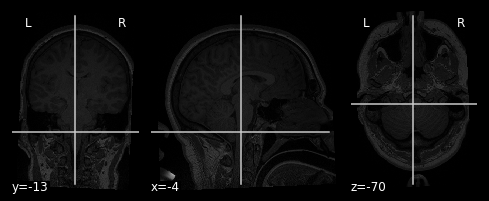

In [5]:
plot_anat(brain)

In [5]:
brain = brain.get_fdata()
brain.shape

(192, 352, 352)

In [6]:
sld_sagital = IntSlider(min=0, max=brain.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=brain.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=brain.shape[2]-1, step=1, continuous_update=True)

In [7]:
def vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_img(brain[coordinate_sagital,:,:])
    if axis == 'coronal':
        plot_img(brain[:,coordinate_coronal ,:])
    if axis == 'axial':
        plot_img(brain[:,:, coordinate_axial])

In [8]:
interact(vary_coordinate, 
         coordinate_axial = sld_axial,
         coordinate_sagital = sld_sagital,
         coordinate_coronal = sld_coronal,
         axis = 'axial')

interactive(children=(IntSlider(value=0, description='coordinate_sagital', max=191), IntSlider(value=0, descri…

<function __main__.vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis=None)>

In [9]:
#We consider only one slice
A1 = brain[:,:,225].T

In [10]:
print(f'mean = {A1.mean()}')
print(f'variance = {A1.var()}')

mean = 211.5997869318182
variance = 25163.32228096786


In [11]:
#GLobal histogram equalization
A1_to_cv = np.uint8(cv2.normalize(A1, None, 0, 255, cv2.NORM_MINMAX))
A2 = cv2.equalizeHist(A1_to_cv)

#Local histogram equalization
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#A2 = clahe.apply(A1_to_cv)

In [12]:
print(f'mean = {A2.mean()}')
print(f'variance = {A2.var()}')

mean = 124.1417939157197
variance = 5620.130063164442


In [13]:
A1 = cv2.resize(A1, (256, 256))
A2 = cv2.resize(A2, (256, 256))

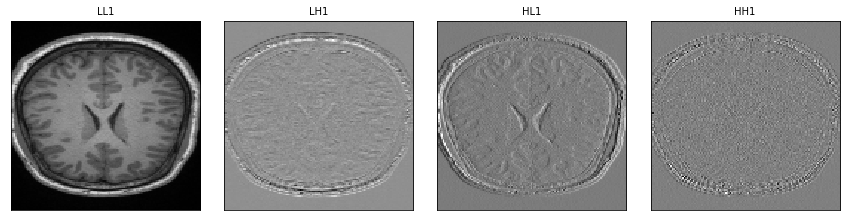

In [14]:
titles = ['LL1', 'LH1', 'HL1', 'HH1']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A1, w)

LL1, (LH1, HL1, HH1) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()



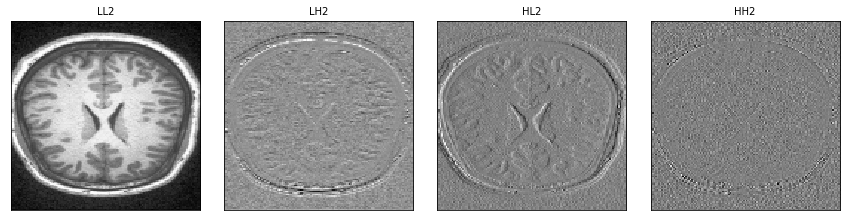

In [15]:
titles = ['LL2', 'LH2', 'HL2', 'HH2']

w = pywt.Wavelet('db1')
coeffs = pywt.dwt2(A2, w)

LL2, (LH2, HL2, HH2) = coeffs

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()


## SVD of LL's 

In [16]:
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)

## Different methods of finding $\xi$

In [17]:
xi_1 = S2[0]/S1[0]

In [18]:
xi_2 = U2.max()/U1.max()

In [19]:
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())

## New $\Sigma$ 

In [20]:
def new_sigma1(sigma2, xi):
    return xi*sigma2

In [21]:
def new_sigma2(sigma1, sigma2, xi):
    return 0.5*(xi*sigma1+sigma2/xi)

In [22]:
def new_sigma3(sigma1, sigma2, xi, mu):
    return mu*xi*sigma1 + (1-mu)*sigma2/xi

## New LL 

In [23]:
def new_LL(new_sigma):
    new_sigma = np.diag(new_sigma)
    return U2 @ new_sigma @ V2

## Experiments with different approaches

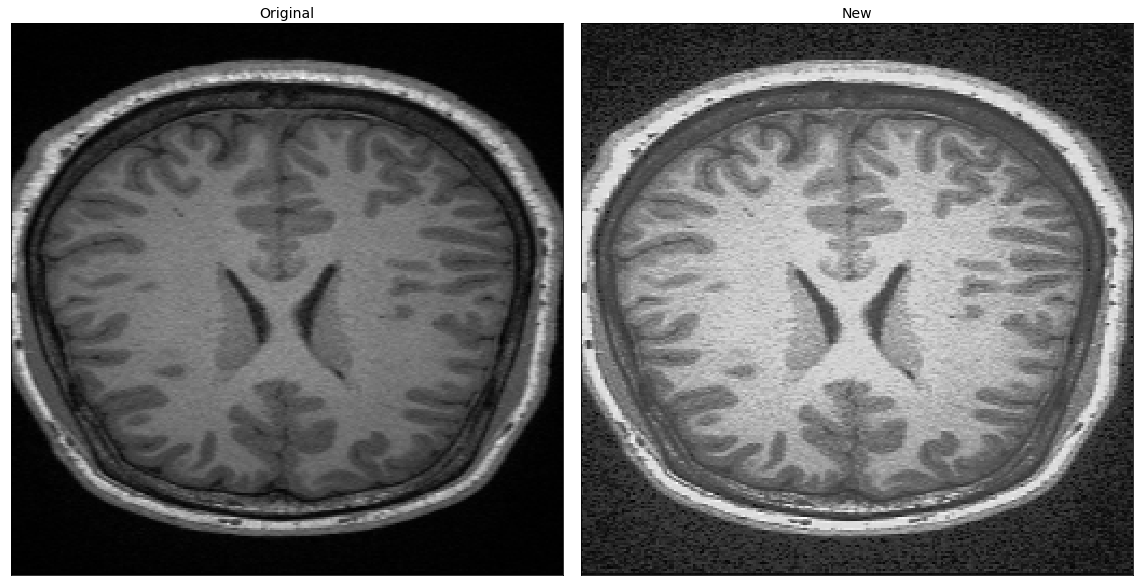

In [24]:
# Article of 2014
new_S = new_sigma1(S2, xi_2)
LL = new_LL(new_S)
brain1 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [25]:
brain1 = brain1 + np.abs(brain1.min())
brain1 = brain1/brain1.max()

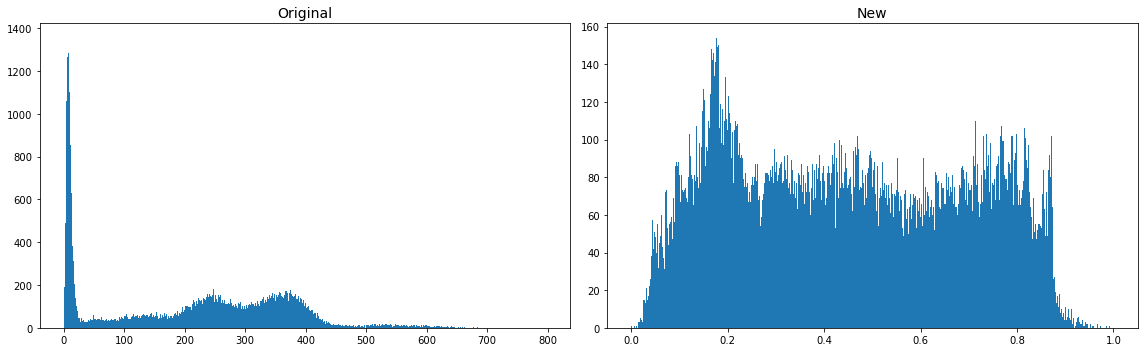

In [26]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain1]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

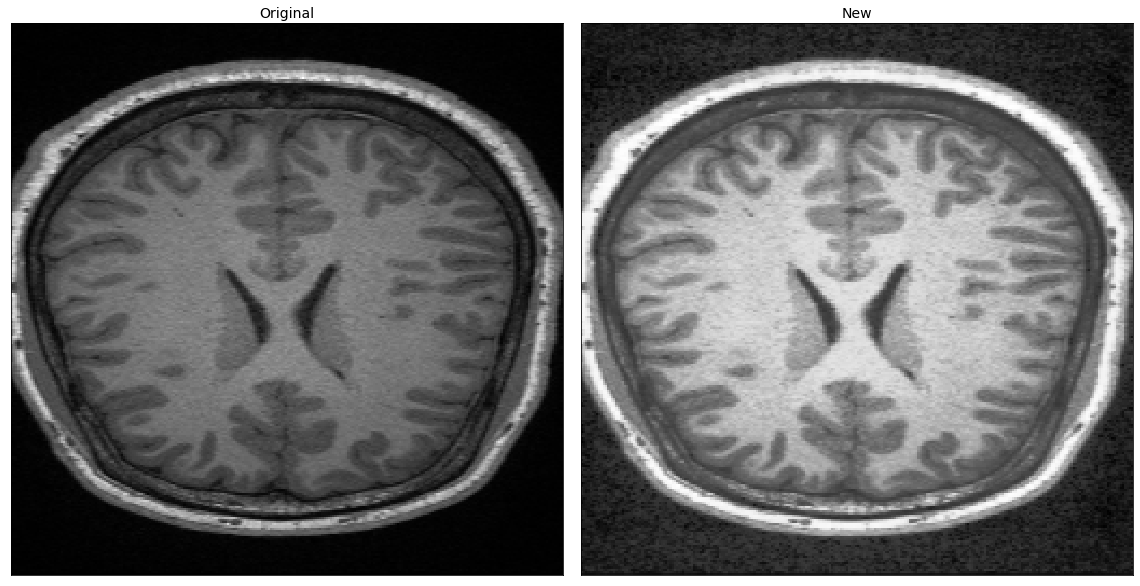

In [27]:
# Article of 2015
new_S = new_sigma2(S1, S2, xi_3)
LL = new_LL(new_S)
brain2 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [28]:
brain2 = brain2 + np.abs(brain2.min())
brain2 = brain2/brain2.max()

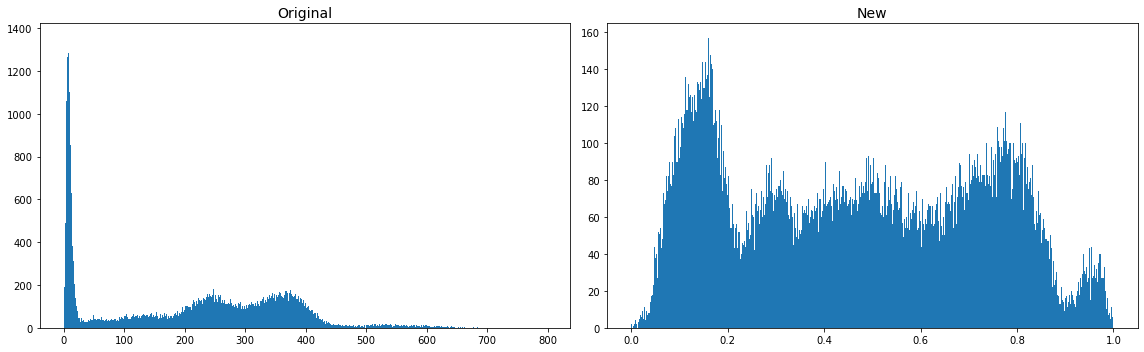

In [29]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain2]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

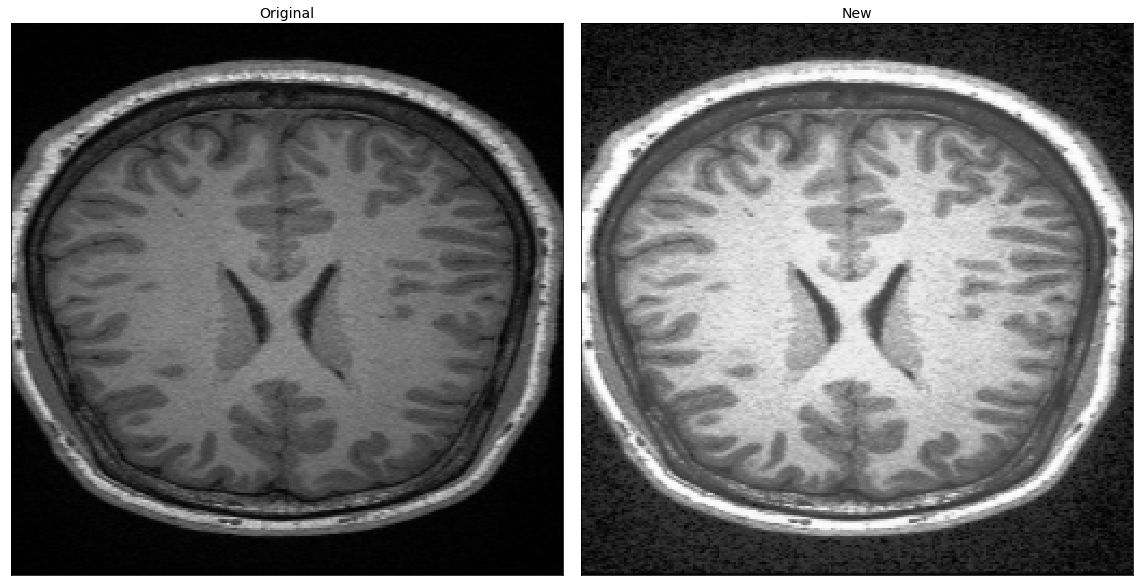

In [30]:
# Main article

mu = 0.1
new_S = new_sigma3(S1, S2, xi_3, mu)
LL = new_LL(new_S)
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

In [31]:
brain3 = brain3 + np.abs(brain3.min())
brain3 = brain3/brain3.max()

In [32]:
brains_3 = []
for mu in np.linspace(0,1, 20):
    new_S = new_sigma3(S1, S2, xi_3, mu)
    LL = new_LL(new_S)
    brain = pywt.idwt2((LL, (LH2, HL2, HH2)), w)
    brain = brain + np.abs(brain.min())
    brain = brain/brain.max()
    brains_3.append(brain)

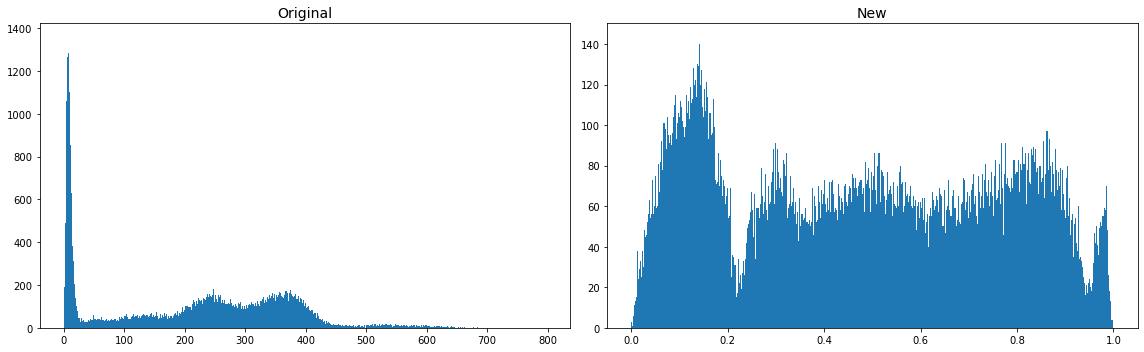

In [33]:
titles = ['Original', 'New']
fig = plt.figure(figsize=(16, 5))
for i, a in enumerate([A1, brain3]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.hist(a.reshape(-1), bins = 1000)
    ax.set_title(titles[i], fontsize=14)
fig.tight_layout()
plt.show()

## Alternative methods

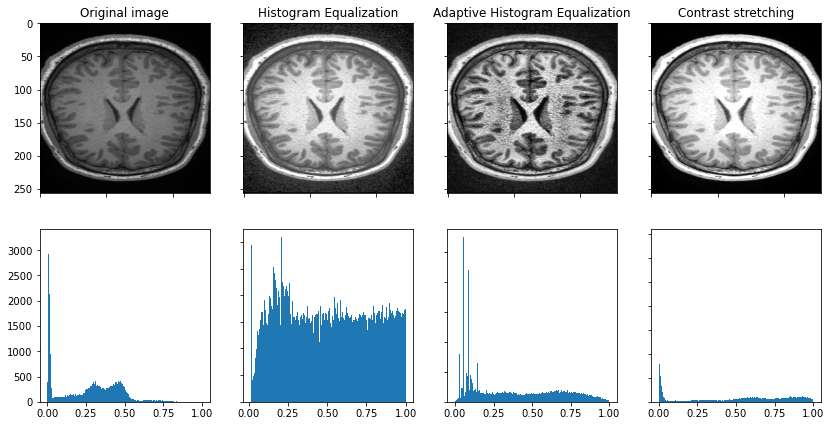

In [34]:
image = A1/A1.max()
image_eq = exposure.equalize_hist(image)
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
pd, pu = np.percentile(image, (8, 92))
image_rescale = exposure.rescale_intensity(image, in_range=(pd, pu))


fig, axs = plt.subplots(2, 4,figsize = (14,7))
axs[0, 0].imshow(image, cmap = 'gray')
axs[0, 0].set_title('Original image')
axs[0, 1].imshow(image_eq, cmap = 'gray')
axs[0, 1].set_title('Histogram Equalization')
axs[0, 2].set_title('Adaptive Histogram Equalization')
axs[0, 2].imshow(image_adapteq, cmap = 'gray')
axs[0, 3].set_title('Contrast stretching')
axs[0, 3].imshow(image_rescale, cmap = 'gray')

axs[1, 0].hist(image.reshape(-1), bins = 400)
axs[1, 1].hist(image_eq.reshape(-1), bins = 400)
axs[1, 2].hist(image_adapteq.reshape(-1), bins = 400)
axs[1, 3].hist(image_rescale.reshape(-1), bins = 400)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Metrics

In [36]:
from metrics import psnr, qrcm, ssim, EME, AMBE

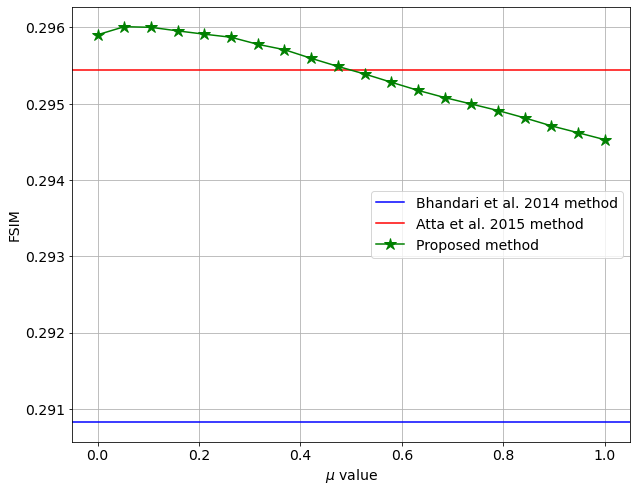

In [46]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(fsim(A1.reshape(256,256,1),brain1.reshape(256,256,1)), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(fsim(A1.reshape(256,256,1),brain2.reshape(256,256,1)), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [fsim(A1.reshape(256,256,1),x.reshape(256,256,1)) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('FSIM')
plt.grid(True)
plt.show()

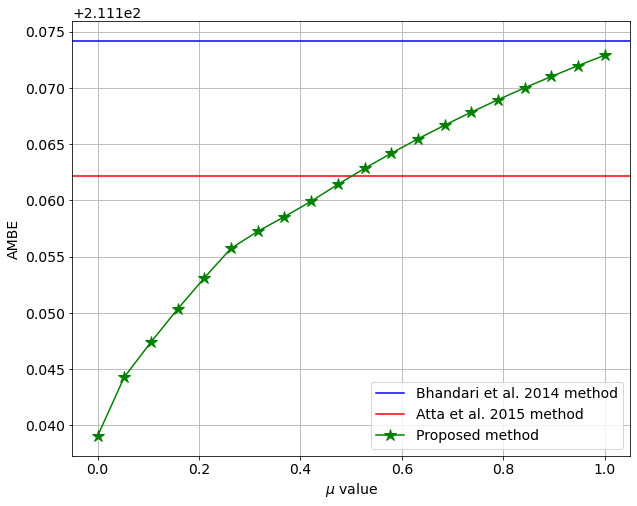

In [37]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(AMBE(brain1,A1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(AMBE(brain2,A1), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [AMBE(x,A1) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('AMBE')
plt.grid(True)
plt.show()

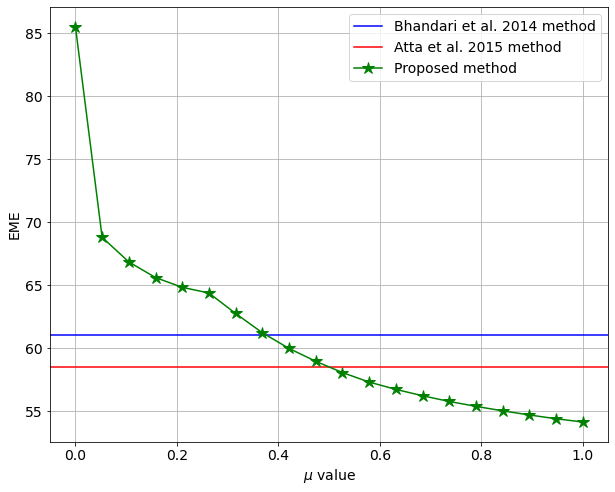

In [134]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(EME(brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(EME(brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [EME(x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('EME')
plt.grid(True)
plt.show()

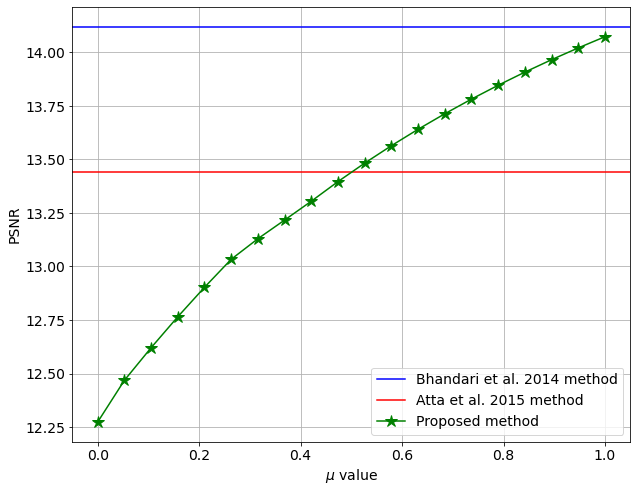

In [34]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(psnr(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(psnr(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [psnr(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

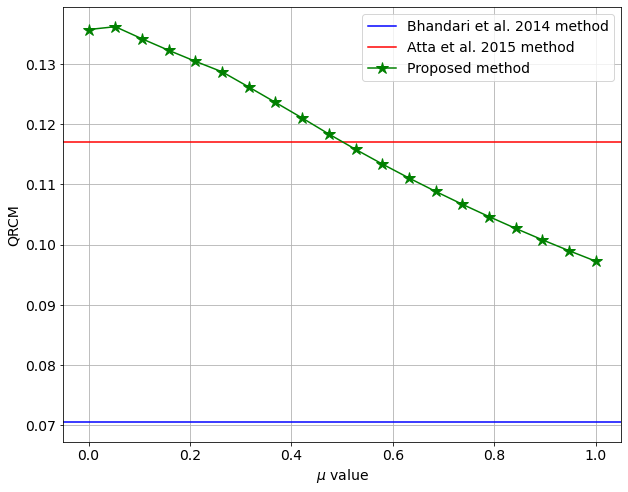

In [35]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(qrcm(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(qrcm(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [qrcm(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('QRCM')
plt.grid(True)
plt.show()

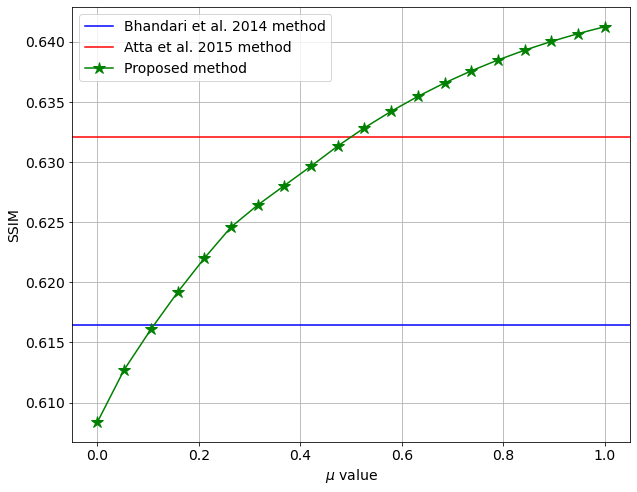

In [36]:
plt.figure(figsize=(10,8))
plt.rc('font', **{'size':14})
plt.axhline(ssim(A1, brain1), color = 'b', label = 'Bhandari et al. 2014 method')
plt.axhline(ssim(A1, brain2), color = 'r', label = 'Atta et al. 2015 method')
plt.plot(np.linspace(0,1,20), [ssim(A1,x) for x in brains_3], '*-', markersize=12, color = 'g', label = 'Proposed method')
plt.xlabel('$\mu$ value')
plt.legend()
plt.ylabel('SSIM')
plt.grid(True)
plt.show()

# Time measurement

In [26]:
w = pywt.Wavelet('db1')
mu = 0.1

In [30]:
%%timeit -r 10
A2 = (A1 - A1.min())/(A1.max() - A1.min())
coeffs = pywt.dwt2(A1, w)
LL1, (LH1, HL1, HH1) = coeffs
coeffs = pywt.dwt2(A2, w)
LL2, (LH2, HL2, HH2) = coeffs
U1, S1, V1 = np.linalg.svd(LL1, full_matrices = False)
U2, S2, V2 = np.linalg.svd(LL2, full_matrices = False)
xi_3 = (U2.max() + V2.max())/(U1.max() + V1.max())
new_S = new_sigma3(S1, S2, xi_3, mu)
new_sigma = np.diag(new_S)
LL = U2 @ new_sigma @ V2
brain3 = pywt.idwt2((LL, (LH2, HL2, HH2)), w)

30.9 ms ± 9.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [31]:
time = 30.9
fps = int(1000 / time)
print('FPS =',fps)

FPS = 32


- This speed make it possible to use this method for online image enhancement